### Results for all cell types. 


I want
* general counts
* coloc between the pc1/2/control, and gwas
* annotation enrichments


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [3]:
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])

pcqtl_output_dir = "output/pcqtl_proteincoding"
eqtl_output_dir = "output/control_eqtl_proteincoding"
clusters_dir = "output/clusters_proteincoding_tami"
overlap_output_dir = "output/overlap_proteincoding"

## Fraction of eqtl cs that overlap with pc cs as a function of the eqtl cs sharing

ie a cs that is shared by multiple genes individually is more likely to be picked up by a pc

In [4]:
tissue_id = 'Cells_Cultured_fibroblasts'
pc1_susie_df = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_1.susie.txt', sep='\t', index_col=0)
pc2_susie_df = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_2.susie.txt', sep='\t', index_col=0)
e_susie_df = pd.read_csv(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0)

overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

#### inspired by this plot I was making for single tissues earlier

A bit too much information on this, so the following plots pull out and highlight key points (ie more liekly to a pcqtl if a signal for multiple control eqtls)

In [5]:
def get_pc_labels(row, pc1_col, pc2_col):
    if row[pc1_col]>0 and row[pc2_col]>0:
        return 'pc_1_and_pc_2'
    elif row[pc1_col]>0:
        return 'pc_1'
    elif row[pc2_col]>0:
        return 'pc_2'
    else: 
        return 'no'

overlap_df['label_pc_overlap'] = overlap_df.progress_apply(get_pc_labels, args=('num_pc1_overlap', 'num_pc2_overlap'), axis=1)
overlap_df['label_pc_samelead'] = overlap_df.progress_apply(get_pc_labels, args=('num_pc1_samelead', 'num_pc2_samelead'), axis=1)

  0%|          | 0/3880 [00:00<?, ?it/s]

  0%|          | 0/3880 [00:00<?, ?it/s]

If we look at this by lead variant, we need to group by the same lead variant id, so that we dont end up with double counting. If we look at credible set overlap genrally, I think the best thing to do would be to merge all overlapping credible sets (TODO write code for this). For now, I just use the lead variant

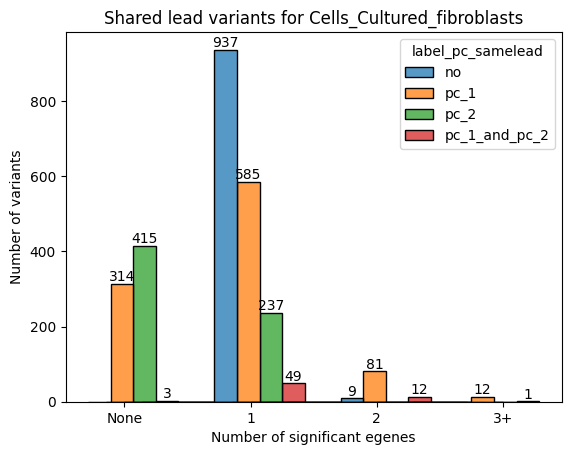

In [6]:
overlap_df['num_e_samelead_clip'] = np.clip(overlap_df['num_e_samelead'], 0, 3)
# each independent signal/lead variant should be represented only once 
plot_overlap_df = overlap_df.drop_duplicates(subset='lead_variant_id')

y=sns.histplot(plot_overlap_df, x='num_e_samelead_clip', hue='label_pc_samelead', multiple='dodge', hue_order=['no', 'pc_1', 'pc_2', 'pc_1_and_pc_2'], shrink=5)
for i in range(len(y.containers)):
    labels = [str(v) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
y.set_xticks([0,1,2,3])
y.set_xticklabels(['None', '1', '2', '3+'])
plt.title(f'Shared lead variants for {tissue_id}')
plt.xlabel('Number of significant egenes')
plt.ylabel('Number of variants')
plt.show()

#### all tissue version

We can now also talk about credible set overlaps, since as a ratio this accounts for double counting

In [7]:
def get_num_items(string_list):
    return len(ast.literal_eval(string_list))

def get_num_matching_cluster(row, pc_column='pc1_overlap'):
    # this assumes that there is only 1 matching e_overlap
    cluster_list = [s.split('_') for s in ast.literal_eval(row[pc_column])]
    # returns the number of clusters that overlap the cs and have the gene in the cluster
    return len(cluster_list) 


def calculate_ratio_error(A, B):
    # Calculate errors based on Poisson statistics
    error_A = np.sqrt(A)
    error_B = np.sqrt(B)
    # Calculate ratio
    try:
        R = A / B
    except ZeroDivisionError:
        return np.nan, np.nan
    # Propagate errors to the ratio
    error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)

    return R, error_R

In [8]:
# match 

def get_ratios(overlap_df, upper_limit=5, pc_overlap_col='num_pc1_overlap', e_overlap_col='num_e_overlap'):
    rs=[]
    r_errors=[]
    for egene_overlap_num in range(1,upper_limit):
        count_overlap_pc1 = (overlap_df[overlap_df[e_overlap_col] == egene_overlap_num][pc_overlap_col]>0).sum()
        total = len(overlap_df[overlap_df[e_overlap_col] == egene_overlap_num])
        r, r_error = calculate_ratio_error(count_overlap_pc1, total)
        rs.append(r)
        r_errors.append(r_error)
    return rs, r_errors
    

#### credible set overlap

/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = A / B
/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)


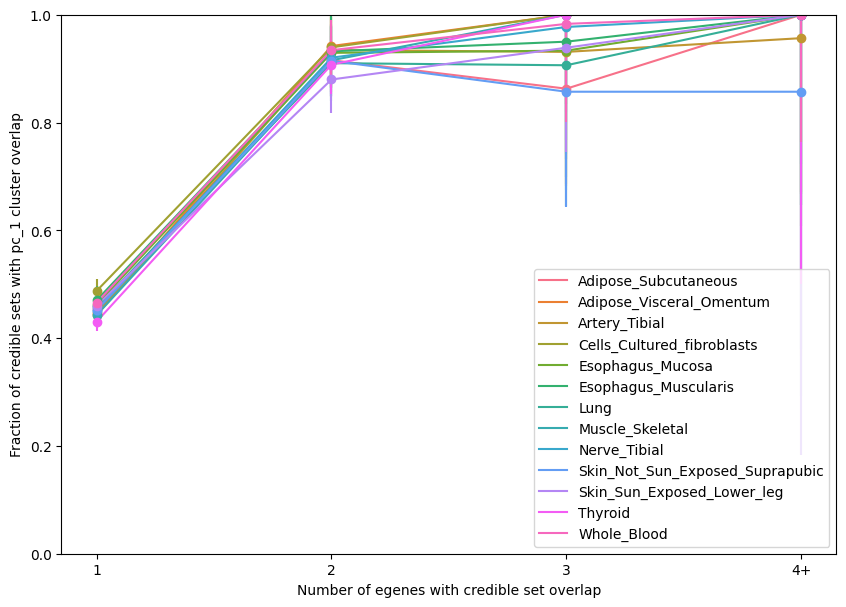

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

p = sns.color_palette()
# load in each tissue
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'].copy()
    # get ratio values
    ratios, ratio_errors = get_ratios(e_overlap_df)
    # plot
    color=sns.color_palette('husl', len(tissue_ids))[i]
    sns.lineplot(x=range(1,5), y=ratios, ax=ax, color=color, label=tissue_id)
    ax.errorbar(x=range(1,5), y=ratios, yerr=ratio_errors, fmt='o', color=color)

ax.set_xticks([1,2,3, 4])
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2', '3', '4+'])
plt.legend()

plt.xlabel('Number of egenes with credible set overlap')
plt.ylabel('Fraction of credible sets with pc_1 cluster overlap')
plt.show()


/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = A / B
/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42765894/ipykernel_48940/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)


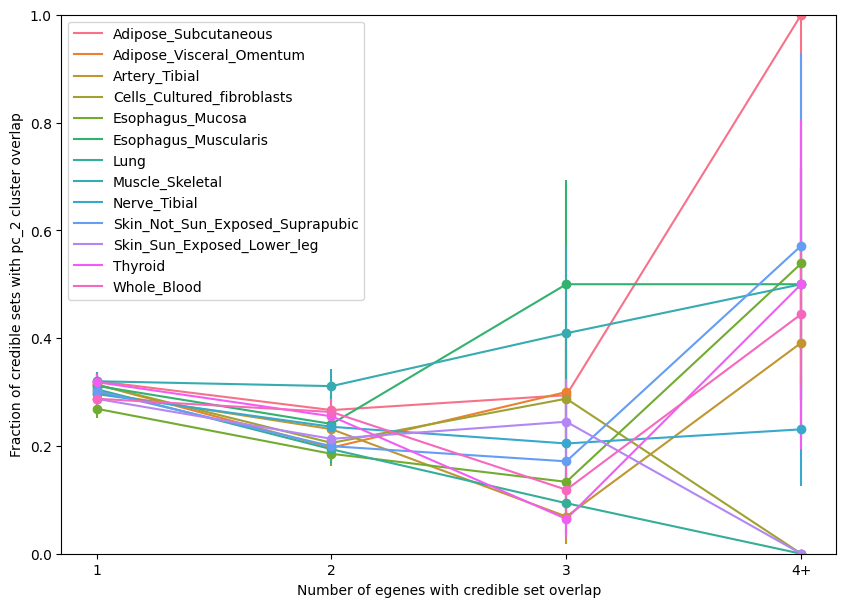

In [11]:
# some concern this is due to underlying "overlapability" of credible sets
# if this were the case we'd expect a similar trend for pc_2

fig, ax = plt.subplots(figsize=(10,7))

p = sns.color_palette()
# load in each tissue
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'].copy()
    # get ratio values
    ratios, ratio_errors = get_ratios(e_overlap_df,pc_overlap_col='num_pc2_overlap')
    # plot
    color=sns.color_palette('husl', len(tissue_ids))[i]
    sns.lineplot(x=range(1,5), y=ratios, ax=ax, color=color, label=tissue_id)
    ax.errorbar(x=range(1,5), y=ratios, yerr=ratio_errors, fmt='o', color=color)

ax.set_xticks([1,2,3, 4])
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2', '3', '4+'])
plt.legend()

plt.xlabel('Number of egenes with credible set overlap')
plt.ylabel('Fraction of credible sets with pc_2 cluster overlap')
plt.show()


[Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4+')]

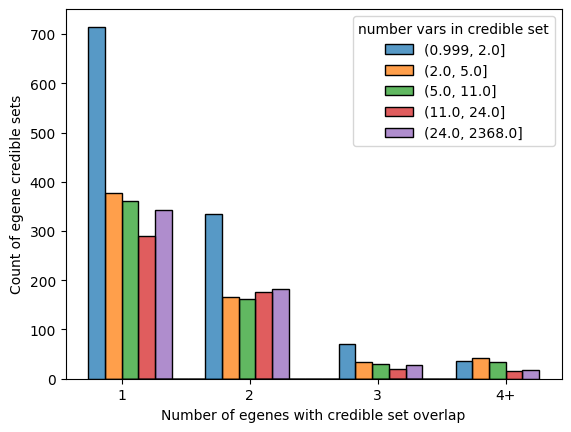

In [10]:
overlap_df['variant_list'].apply(get_num_items)
y=sns.histplot(x=np.clip(e_overlap_df['e_overlap'].apply(get_num_items), 0,4), hue=pd.qcut(e_overlap_df['variant_list'].apply(get_num_items), 6, duplicates='drop'), multiple='dodge', shrink=5)
y.get_legend().set_title('number vars in credible set')
plt.xlabel('Number of egenes with credible set overlap')
plt.ylabel('Count of egene credible sets')
y.set_xticks([1,2,3,4])
y.set_xticklabels(['1', '2', '3', '4+'])

#### shared lead variants

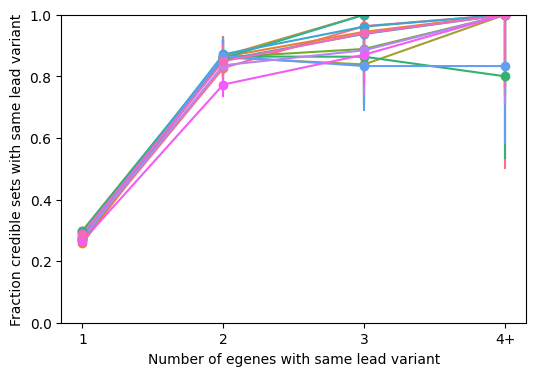

In [11]:
## same plot but for lead variant rather than overlap

# some concern this is due to underlying "overlapability" of credible sets
# if this were the case we'd expect a similar trend for pc_2

fig, ax = plt.subplots(figsize=(6,4))

p = sns.color_palette()
# load in each tissue
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')
    e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'].copy()
    # get ratio values
    ratios, ratio_errors = get_ratios(e_overlap_df,pc_overlap_col='num_pc1_samelead', e_overlap_col='num_e_samelead')
    # plot
    color=sns.color_palette('husl', len(tissue_ids))[i]
    sns.lineplot(x=range(1,5), y=ratios, ax=ax, color=color, label=tissue_id)
    ax.errorbar(x=range(1,5), y=ratios, yerr=ratio_errors, fmt='o', color=color)

ax.set_xticks([1,2,3, 4])
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2', '3', '4+'])
#plt.legend(loc='upper left')
plt.legend([],[], frameon=False)
plt.xlabel('Number of egenes with same lead variant')
plt.ylabel('Fraction credible sets with same lead variant')
plt.show()



/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1190647217.py:21: RuntimeWarning: invalid value encountered in scalar divide
  error_R = R * np.sqrt((error_A / A)**2 + (error_B / B)**2)
/local/scratch/klawren/slrmtmp

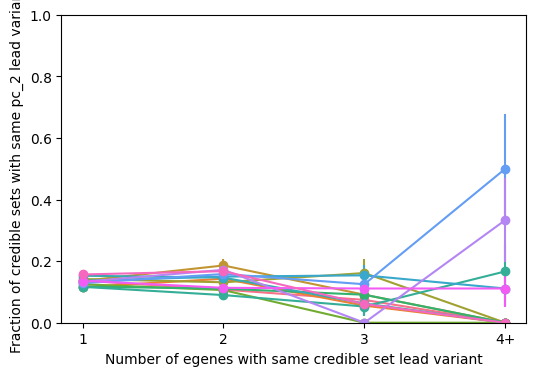

In [12]:
## same plot but for lead variant rather than overlap

# some concern this is due to underlying "overlapability" of credible sets
# if this were the case we'd expect a similar trend for pc_2

fig, ax = plt.subplots(figsize=(6,4))

p = sns.color_palette()
# load in each tissue
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')
    e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl'].copy()
    # get ratio values
    ratios, ratio_errors = get_ratios(e_overlap_df,pc_overlap_col='num_pc2_samelead',  e_overlap_col='num_e_samelead')
    # plot
    color=sns.color_palette('husl', len(tissue_ids))[i]
    sns.lineplot(x=range(1,5), y=ratios, ax=ax, color=color, label=tissue_id)
    ax.errorbar(x=range(1,5), y=ratios, yerr=ratio_errors, fmt='o', color=color)

ax.set_xticks([1,2,3, 4])
ax.set_ylim(0, 1)
ax.set_xticklabels(['1', '2', '3', '4+'])
plt.legend(loc='upper left')
plt.legend([],[], frameon=False)


plt.xlabel('Number of egenes with same credible set lead variant')
plt.ylabel('Fraction of credible sets with same pc_2 lead variant')
plt.show()



[Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4+')]

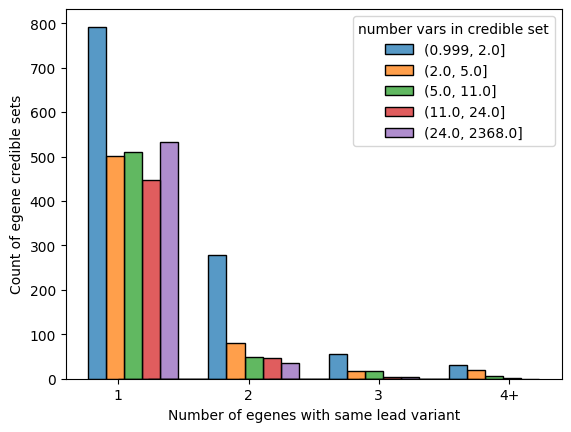

In [13]:
# plot for number variants in credible set, but with same lead rather than cs overlap for x axis
overlap_df['variant_list'].apply(get_num_items)
y=sns.histplot(x=np.clip(e_overlap_df['num_e_samelead'], 0,4), hue=pd.qcut(e_overlap_df['variant_list'].apply(get_num_items), 6, duplicates='drop'), multiple='dodge', shrink=3)
y.get_legend().set_title('number vars in credible set')
plt.xlabel('Number of egenes with same lead variant')
plt.ylabel('Count of egene credible sets')
y.set_xticks([1,2,3,4])
y.set_xticklabels(['1', '2', '3', '4+'])

## sanity checks


In [14]:
# concatenated overlap df for all the tissues
overlap_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_dfs.append(pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t'))
full_overlap_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(overlap_dfs, tissue_ids)])

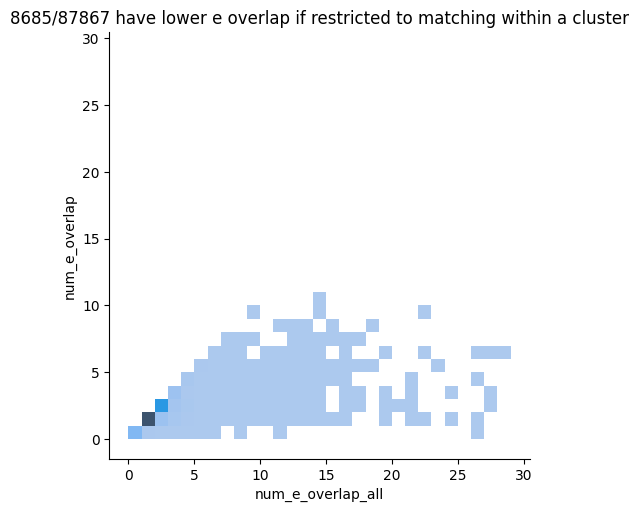

In [15]:
# the _all column versions don't worry about the match being between genes in the same cluster. 
# This should only happen rarely and so the _all and regular versions should look very similar

sns.displot(full_overlap_df, x='num_e_overlap_all', y='num_e_overlap', bins=range(full_overlap_df['num_e_overlap_all'].max()+2))
plt.title('{}/{} have lower e overlap if restricted to matching within a cluster'.format((full_overlap_df['num_e_overlap_all']> full_overlap_df['num_e_overlap']).sum(), len(full_overlap_df)))
plt.show()

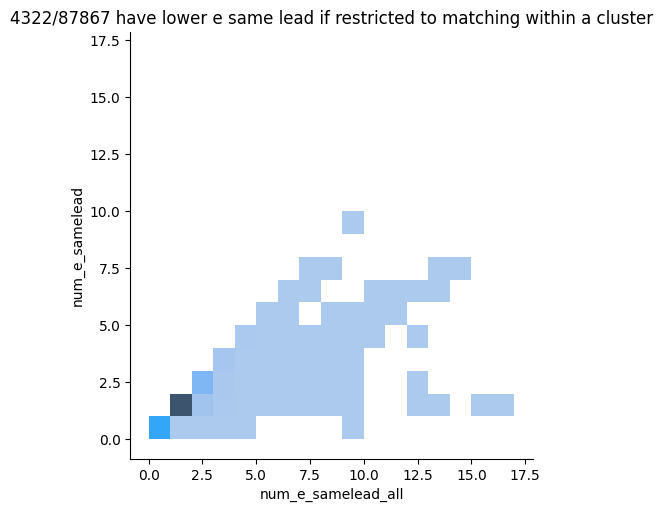

In [16]:
# the _all column versions don't worry about the match being between genes in the same cluster. 
# This should only happen rarely and so the _all and regular versions should look very similar

sns.displot(full_overlap_df, x='num_e_samelead_all', y='num_e_samelead', bins=range(full_overlap_df['num_e_samelead_all'].max()+2))
plt.title('{}/{} have lower e same lead if restricted to matching within a cluster'.format((full_overlap_df['num_e_samelead_all']> full_overlap_df['num_e_samelead']).sum(), len(full_overlap_df)))
plt.show()

# TSS distance

In [17]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

In [18]:
# add in the variant position as a column
overlap_df['lead_variant_pos'] = overlap_df['lead_variant_id'].str.split('_').str[1].astype(int)

In [19]:
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = full_gencode[full_gencode['transcript_id'].isin(row['cluster_id'].split('_'))]
    starts = cluster_gene_df['start'].values
    distances = abs(row['lead_variant_pos'] - starts)
    # return smallest absolute value distance
    idx = np.argmin(distances)
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
# for just the egenes, get the cluster start that actually matched the gene of interest
def get_egene_distance(row):
    assert row['orig_cs_dataset'] =='control_eqtl'
    egene = row['cs_full_id'].split('_e_')[1]
    gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -abs(row['lead_variant_pos']-gene_df.start)
    else:
        return abs(row['lead_variant_pos']-gene_df.start)

In [20]:
# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
overlap_df['cluster_min_distance'] = overlap_df.progress_apply(get_tss, axis=1)/1000
# annotate eqtls with the distance to their egene
e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']
e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)/1000

  0%|          | 0/6111 [00:00<?, ?it/s]

  0%|          | 0/3432 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.42710607/ipykernel_18725/1007742002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)/1000


Text(0.5, 1.0, 'Distribution of lead variant to egene tss distances for control eqtls')

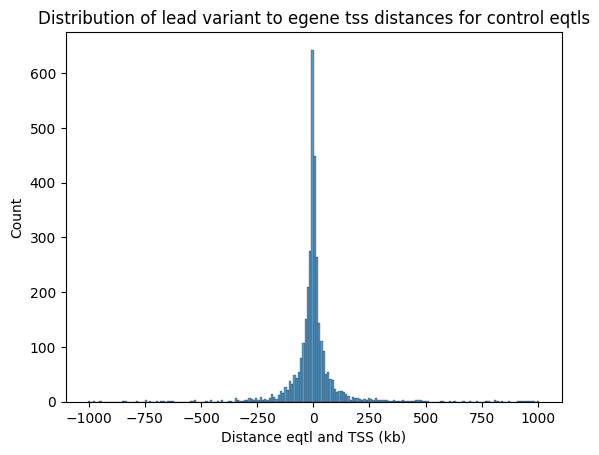

In [21]:
# plot for just the egene distances
sns.histplot(e_overlap_df['egene_distance'], bins=200)
plt.xlabel('Distance eqtl and TSS (kb)')
plt.title('Distribution of lead variant to egene tss distances for control eqtls')

In [22]:
# a dataset that puts egenes in twice, once with a distance to thier egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': pd.concat([overlap_df['cluster_min_distance'], e_overlap_df['egene_distance']]), 
              'dataset':pd.concat([overlap_df['orig_cs_dataset'], pd.Series(['eqtl_egene_only']*len(e_overlap_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'

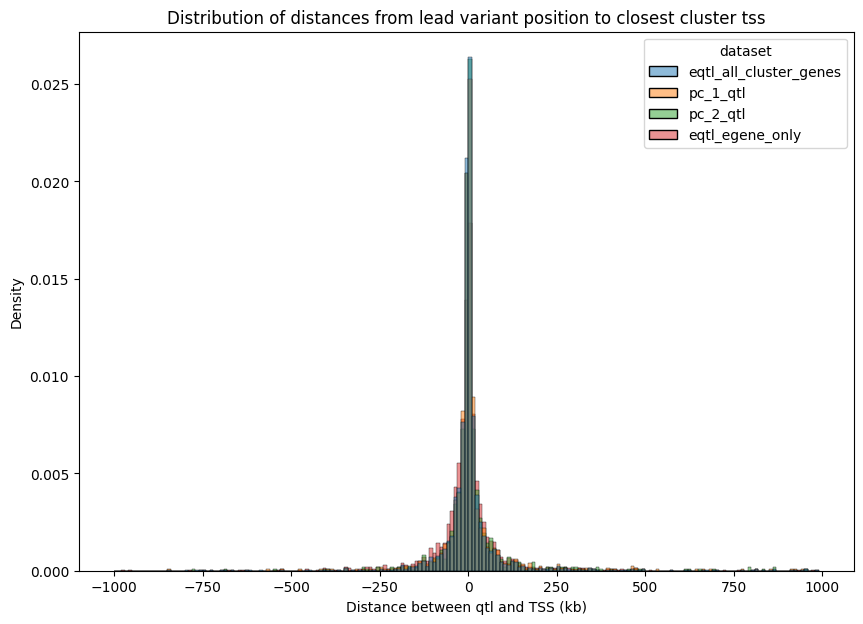

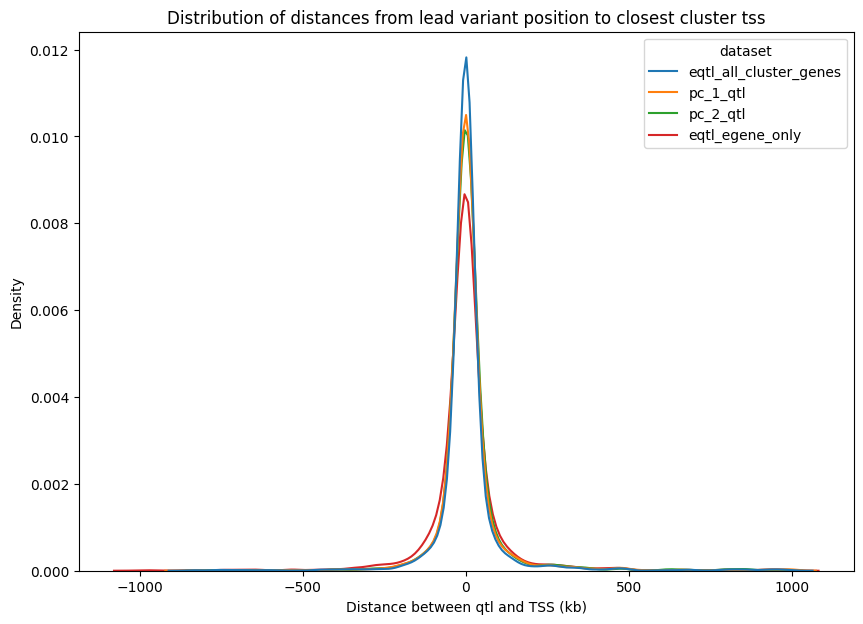

In [23]:
# a few ways to plot that joined dataset
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=joined, x='distance', bins=range(-1000, 1000, 10), hue='dataset', 
            stat='density', ax=ax, common_norm=False)

plt.xlabel('Distance between qtl and TSS (kb)')
plt.title('Distribution of distances from lead variant position to closest cluster tss')
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
sns.kdeplot(data=joined, x='distance', hue='dataset', ax=ax, common_norm=False)

plt.xlabel('Distance between qtl and TSS (kb)')
plt.title('Distribution of distances from lead variant position to closest cluster tss')
plt.show()


the distance from the qtl to just the relevant egene is defiently furhter than the closest in the cluster appraoich, as would sort of be expected

(-100.0, 100.0)

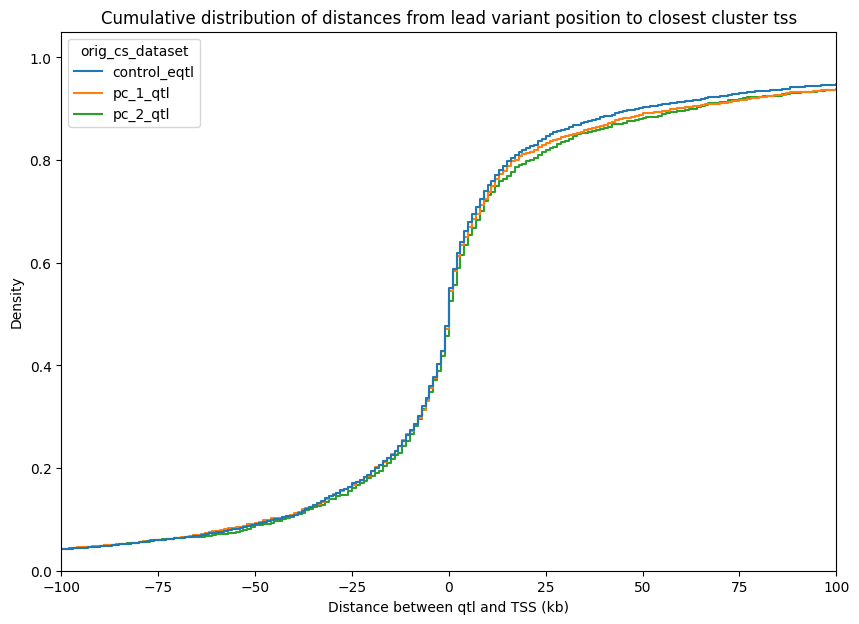

In [24]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
edge=100
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=overlap_df, x='cluster_min_distance', bins=range(-1000, 1000, 1), hue='orig_cs_dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (kb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')
plt.xlim((-edge, edge))

(0.0, 100.0)

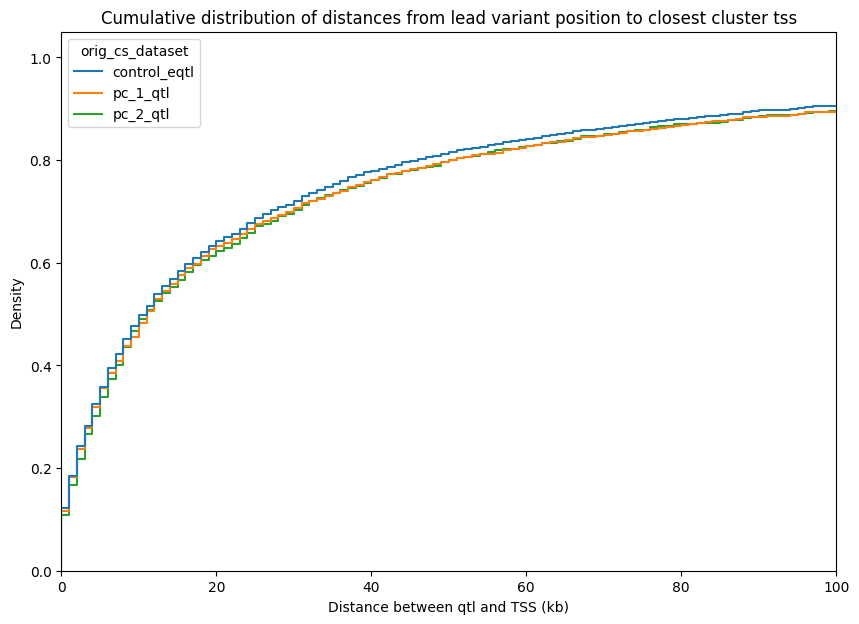

In [25]:
# absolute value of distance for that plot
overlap_df['abs_distance'] = overlap_df['cluster_min_distance'].apply(abs)
edge=100
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=overlap_df, x='abs_distance', bins=range(-1000, 1000, 1), hue='orig_cs_dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (kb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')
plt.xlim((0, edge))

In [26]:
# manhattenplot with credible sets??

